In [1]:
import csv
import datetime as dt
import json
import os
import re
import sys

%matplotlib inline
from dateutil.parser import parse as dt_parse
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-pastel')

In [2]:
# Files are known to start with two-letter country abbrieviations and are of two standard formats (json | csv)
yt_data = {}
yt_category = {}
country_codes = []
figure_list = []

def count_tags(tag_list):
    return(len(tag_list.split("|")))

def parse_datetime(value):
    value = "20" + value
    return(dt.datetime.strptime(value, "%Y.%d.%m"))

def parse_uploadtime(value):
    dt = dt_parse(value)
    dt = dt.replace(tzinfo=None)
    return(dt)

def format_time(datetime_object, wanted_unit):
    if wanted_unit == "day":
        return(datetime_object.strftime("%A"))
    elif wanted_unit == "month":
        return(datetime_object.strftime("%B"))
    elif wanted_unit == "hour":
        return(datetime_object.strftime("%I%p"))

realpath = os.path.abspath('')
raw_data_path = os.path.join(realpath, "raw_data")
clean_data_path = os.path.join(realpath, "clean_Data")

for file in os.listdir(clean_data_path):
    full_path = os.path.join(clean_data_path, file)
    country_code = file[0:2]
    if country_code not in country_codes:
        country_codes.append(country_code)
    yt_data[country_code] = pd.read_csv(full_path, parse_dates=True)
    yt_data[country_code]['country'] = country_code
    yt_data[country_code]['tag_count'] = yt_data[country_code]['tags'].apply(count_tags)

for file in os.listdir(raw_data_path):
    full_path = os.path.join(raw_data_path, file)
    if file.endswith(".json"):
        with open(full_path) as current_json:
            json_dict = json.load(current_json)
            for line in json_dict['items']:
                if line['id'] not in yt_category:
                    yt_category[line['id']] = line['snippet']['title']
                # json files were segregated by country, this is just to check if id varies by country
                elif yt_category[line['id']] != line['snippet']['title']:
                    print(yt_category[line['id']], line['snippet']['title'])

for country in yt_data:
    yt_data[country]['category'] = yt_data[country]['category_id'].astype(str).map(yt_category)
    
country_dict = {
    "FR": "France",
    "MX": "Mexico",
    "US": "United States of America",
    "GB": "United Kingdom of Great Britain and Northern Ireland",
    "DE": "Germany",
    "KR": "Korea",
    "JP": "Japan",
    "RU": "Russian Federation",
    "IN": "India",
    "CA": "Canada",
}
   
all_data = pd.concat([yt_data[country_code] for country_code in country_codes], ignore_index=True)
    
all_data['trending_datetime'] = all_data['trending_date'].apply(parse_datetime)
all_data['publish_datetime'] = all_data['publish_time'].apply(parse_uploadtime)
all_data['publish_to_trend_time'] = all_data['trending_datetime'] - all_data['publish_datetime']
for unit in ['month', 'day', 'hour']:
    if unit != 'hour':
        all_data['trending_{}'.format(unit)] = all_data['trending_datetime'].apply(format_time, args=(unit,))
    all_data['publish_{}'.format(unit)] = all_data['publish_datetime'].apply(format_time, args=(unit,))

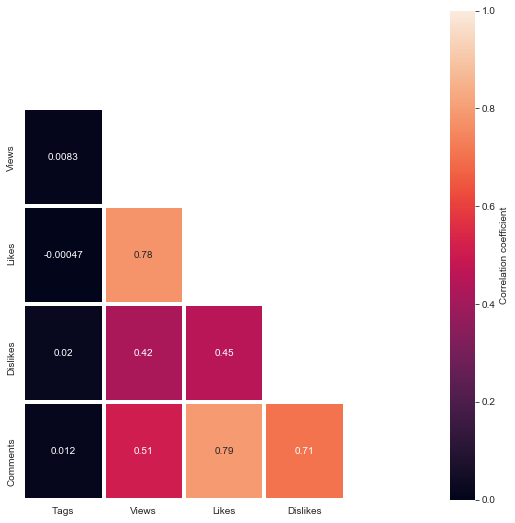

In [3]:
heatmap_list = [
    'tag_count',
    'views',
    'likes',
    'dislikes',
    'comment_count',
]

sns.set_style('whitegrid')

correlations = all_data.loc[:, heatmap_list].corr()
upper_mask = np.triu(correlations)
custom_cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig1, ax1 = plt.subplots(figsize=(9, 9))
sns.heatmap(correlations, mask=upper_mask, annot=True, fmt='.2g', linewidths=3, ax=ax1,
            xticklabels=['Tags', 'Views', 'Likes', 'Dislikes'],
            yticklabels=['Views', 'Likes', 'Dislikes', 'Comments'],
            cbar_kws={'label': 'Correlation coefficient'})
# Readjust the yticks to be in sync after removal of yticklabels
ax1.set_yticks(ax1.get_yticks() + 0.9)
figure_list.append((fig1, 'correlation_heatmap'))

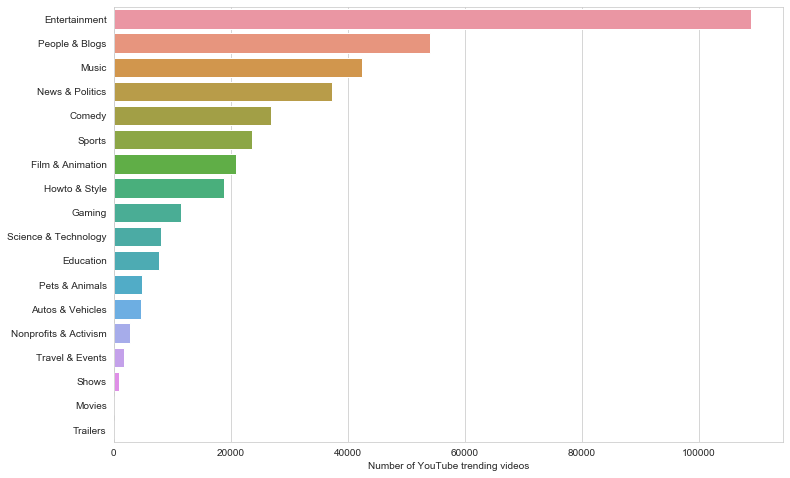

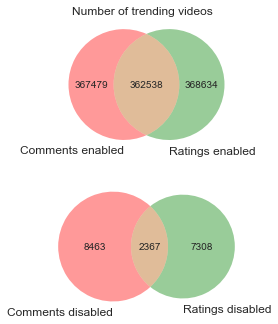

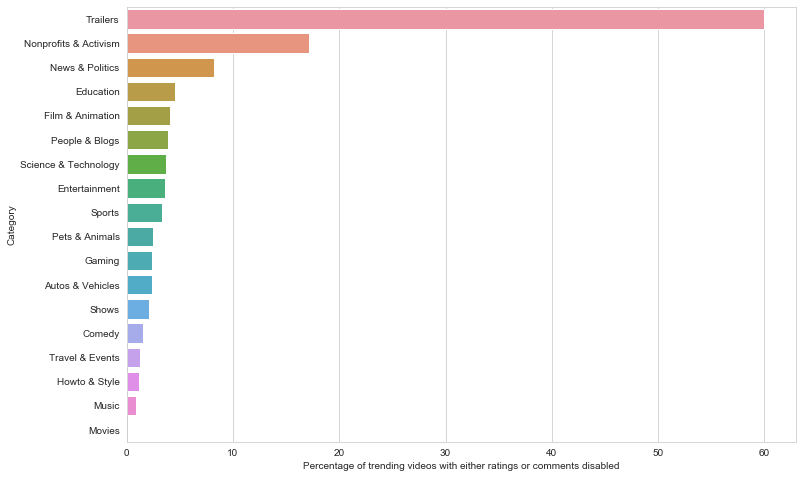

In [4]:
fig2, ax2 = plt.subplots(figsize=(12, 8))
counts = all_data['category'].value_counts()
sns.barplot(counts.values, counts.index, ax=ax2)
ax2.set_xlabel("Number of YouTube trending videos")
# Retaining the yticklabels to define plot order
category_order = [label.get_text() for label in ax2.get_yticklabels()]

fig3, ax3 = plt.subplots(2, 1, figsize=(5, 5))
venn_tuple = (all_data.loc[all_data.comments_disabled == True, 'comments_disabled'].count(),
              all_data.loc[all_data.ratings_disabled == True, 'ratings_disabled'].count(),
              all_data.loc[(all_data.ratings_disabled == True) & (all_data.comments_disabled == True), 'ratings_disabled'].count())
venn2(subsets=venn_tuple, set_labels=('Comments disabled', 'Ratings disabled', 'Comments and ratings disabled'), ax=ax3[1])

venn_tuple = (all_data.loc[all_data.comments_disabled == False, 'comments_disabled'].count(),
              all_data.loc[all_data.ratings_disabled == False, 'ratings_disabled'].count(),
              all_data.loc[(all_data.ratings_disabled == False) & (all_data.comments_disabled == False), 'ratings_disabled'].count())
venn2(subsets=venn_tuple, set_labels=('Comments enabled', 'Ratings enabled', 'Comments and ratings enabled'), 
      ax=ax3[0])
fig3.subplots_adjust(top=0.95)
fig3.suptitle('Number of trending videos')

fig4, ax4 = plt.subplots(figsize=(12, 8))
disabled_counts = all_data.loc[(all_data.comments_disabled == True) | (all_data.ratings_disabled == True), 'category'].value_counts().reindex(category_order, axis='index')
disabled_percentage = disabled_counts / counts * 100
disabled_percentage.sort_values(inplace=True, ascending=False)
sns.barplot(disabled_percentage.values, disabled_percentage.index, ax=ax4)
ax4.set(xlabel="Percentage of trending videos with either ratings or comments disabled", ylabel="Category")

figure_list.extend([(fig2, 'global_categories_barplot'), 
                    (fig3, 'global_comments_ratings_venn'), 
                    (fig4, 'global_comments_ratings_disabled_barplot')])

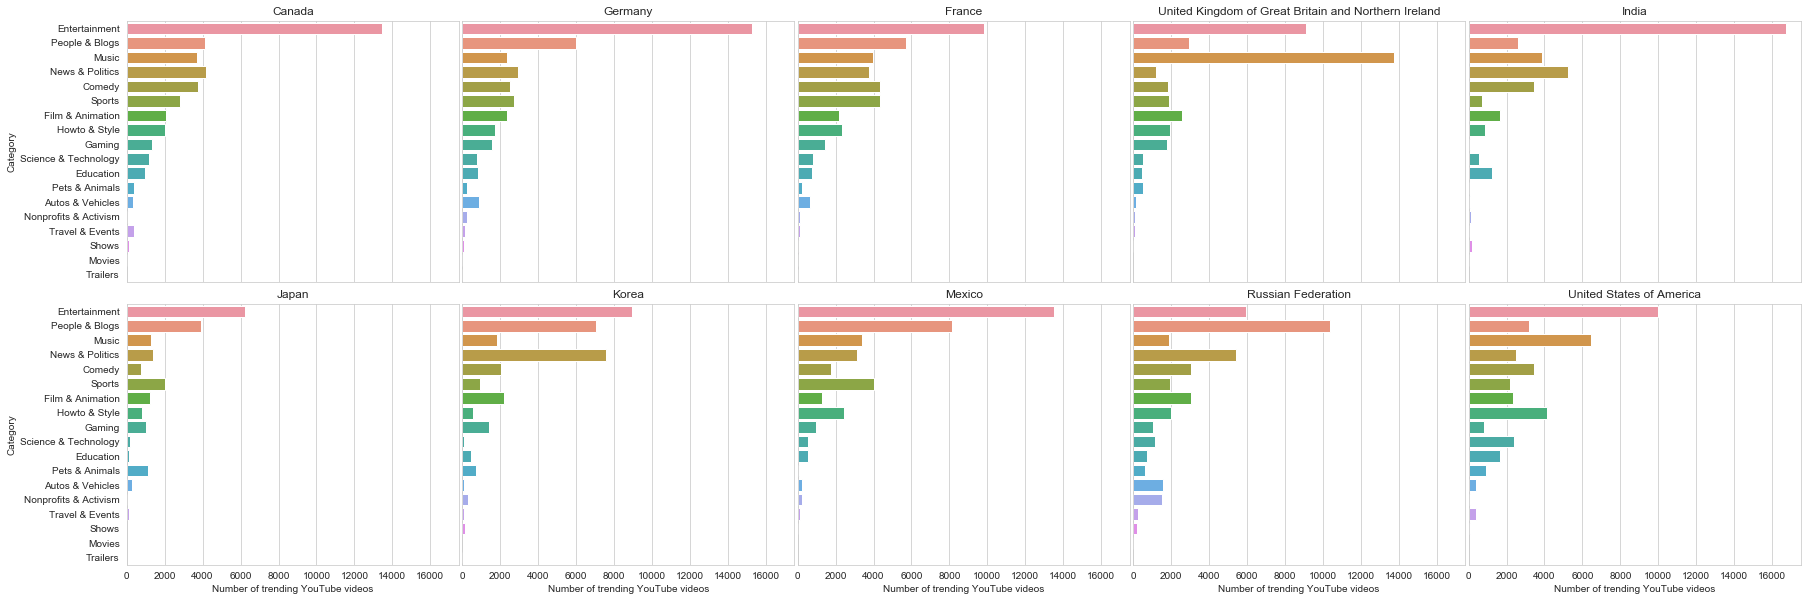

In [5]:
fig5, ax5 = plt.subplots(2, 5, figsize=(30, 10), sharex=True, sharey=True)
row, column = 0, 0
plt.subplots_adjust(wspace=.01, hspace=.085)
for country_code in country_codes:
    current_ax = ax5[row][column]
    current_plot = yt_data[country_code]['category'].value_counts()
    sns.barplot(current_plot.values, current_plot.index, ax=current_ax, order=category_order)
    current_ax.set(xlim=(0, 17500), title=country_dict[country_code])
    if column == 0:
        current_ax.set(ylabel="Category")
    if row == 1:
         current_ax.set(xlabel="Number of trending YouTube videos")
    if column < 4:
        column += 1
    elif row == 0:
        row += 1
        column = 0
        
figure_list.append((fig5, 'all_countries_categories_barplot'))

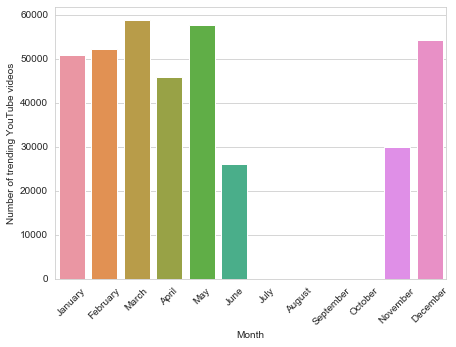

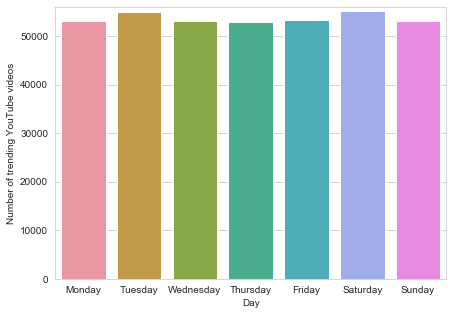

In [6]:
# Trending time analysis

trending_month_count = all_data['trending_month'].value_counts()
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

fig6, ax6 = plt.subplots(figsize=(7, 5))
sns.barplot(trending_month_count.index, trending_month_count.values, ax=ax6, order=month_order)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, horizontalalignment='center')
ax6.set(ylabel='Number of trending YouTube videos', xlabel='Month of trending')

trending_day_count = all_data['trending_day'].value_counts()
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
fig7, ax7 = plt.subplots(figsize=(7, 5))
sns.barplot(trending_day_count.index, trending_day_count.values, ax=ax7, order=day_order)
ax7.set(ylim=(0, 56000))
ax7.set(ylabel='Number of trending YouTube videos', xlabel='Day of trending')

figure_list.extend([(fig6, 'global_trending_month_barplot'),
                    (fig7, 'global_trending_day_barplot')])


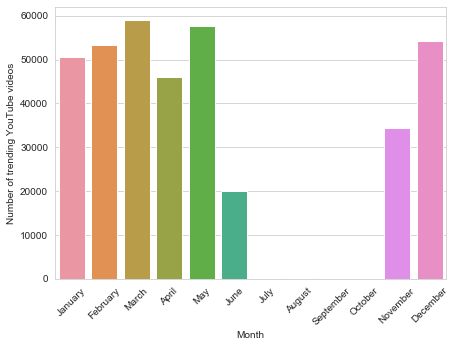

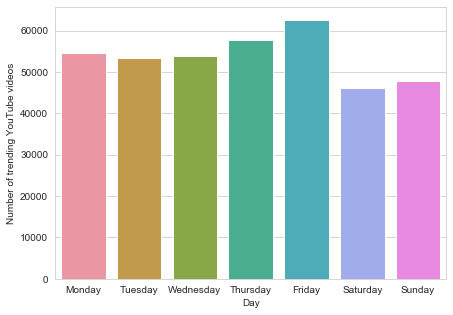

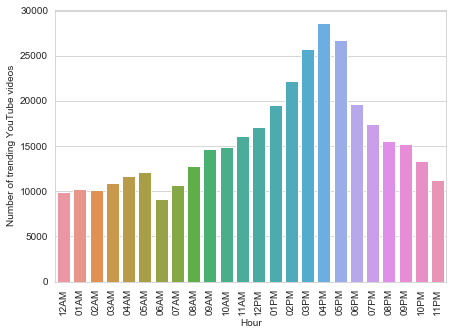

In [7]:
# Published time analysis

def sort_hours(time_value):
    flat_time = int(time_value[0:2])
    modifier = time_value[2:4]
    if modifier == "PM":
        flat_time += 12
    if flat_time == 12:
        flat_time = 0
    if flat_time == 24:
        flat_time = 12
    return flat_time

publish_month_count = all_data['publish_month'].value_counts()
fig8, ax8 = plt.subplots(figsize=(7, 5))
sns.barplot(publish_month_count.index, publish_month_count.values, ax=ax8, order=month_order)
ax8.set_xticklabels(ax8.get_xticklabels(), rotation=45, horizontalalignment='center')
ax8.set(ylabel='Number of trending YouTube videos', xlabel='Month of upload')

publish_day_count = all_data['publish_day'].value_counts()
fig9, ax9 = plt.subplots(figsize=(7, 5))
sns.barplot(publish_day_count.index, publish_day_count.values, ax=ax9, order=day_order)
ax9.set(ylabel='Number of trending YouTube videos', xlabel='Day of upload')

publish_hour_count = all_data['publish_hour'].value_counts()
hour_order = sorted(all_data['publish_hour'].unique().tolist(), key=sort_hours)
fig10, ax10 = plt.subplots(figsize=(7, 5))
sns.barplot(publish_hour_count.index, publish_hour_count.values, ax=ax10, order=hour_order)
ax10.set_xticklabels(ax10.get_xticklabels(), rotation=90, horizontalalignment='center')
ax10.set(ylabel='Number of trending YouTube videos', xlabel='Hour of upload')

figure_list.extend([(fig8, 'global_publish_month_barplot'),
                    (fig9, 'global_publish_day_barplot'),
                    (fig10,'global_publish_hour_barplot')])

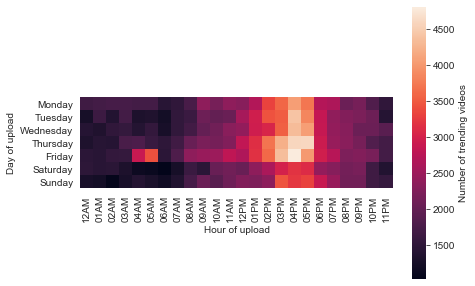

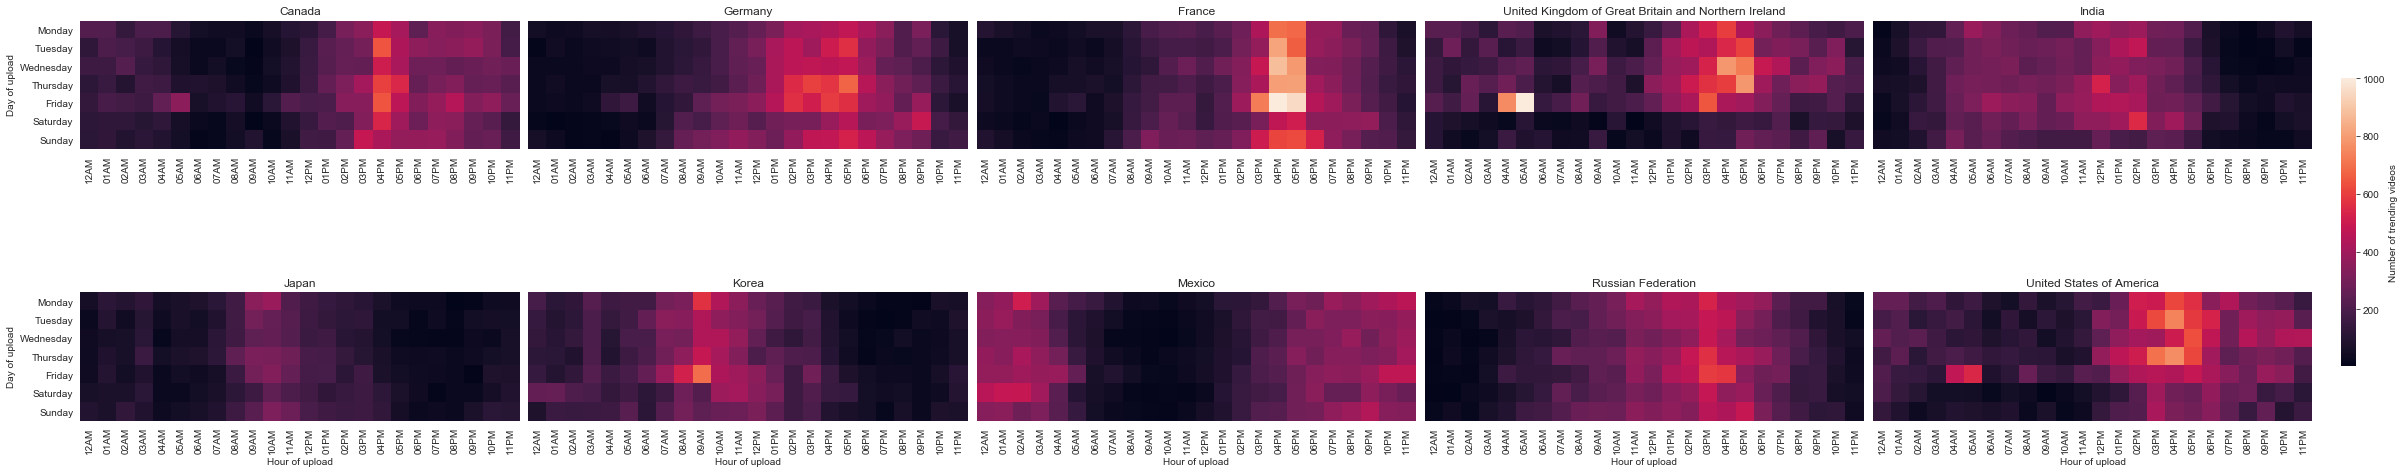

In [8]:
# Day and hour heatmap plots
fig11, ax11 = plt.subplots(figsize=(7, 5))
day_hour_group = all_data.loc[:, ['publish_hour', 'publish_day', 'video_id']]
day_hour_group = day_hour_group.pivot_table(index='publish_day', columns='publish_hour', 
                                            values='video_id', aggfunc='count')
day_hour_group = day_hour_group.reindex(day_order, axis='index')
day_hour_group = day_hour_group.reindex(hour_order, axis='columns')
sns.heatmap(day_hour_group, ax=ax11, #cmap='YlGnBu',
            cbar_kws={'label': 'Number of trending videos'},
            square=True)
ax11.set(xlabel="Hour of upload", ylabel="Day of upload")

fig12, ax12 = plt.subplots(2, 5, figsize=(40, 10), sharex=False, sharey=True)
row, column = 0, 0
cbar = False
cbar_fixed = fig12.add_axes([.91, .3, .005, .4])
for country in country_codes:
    currentax = ax12[row][column]
    if column == 4 and row == 1:
        cbar = True
        cbar_ax = cbar_fixed
    else:
        cbar = False
        cbar_ax = None
    country_day_hour_group = all_data.loc[all_data['country'] == country, ['publish_hour', 'publish_day', 'video_id']]
    country_day_hour_group = country_day_hour_group.pivot_table(index='publish_day', columns='publish_hour',
                                                                values='video_id', aggfunc='count')
    country_day_hour_group = country_day_hour_group.reindex(day_order, axis='index')
    country_day_hour_group = country_day_hour_group.reindex(hour_order, axis='columns')
    sns.heatmap(country_day_hour_group, ax=currentax,
                cbar_kws={'label': 'Number of trending videos'}, vmax=1000,
                cbar=cbar, cbar_ax=cbar_ax, square=True)
    if column == 0:
        currentax.set(ylabel="Day of upload")
    else:
        currentax.set(ylabel="")
    if row == 1:
        currentax.set(xlabel="Hour of upload")
    else:
        currentax.set(xlabel="")
    currentax.set(title=country_dict[country])
    if column < 4:
        column += 1
    elif row == 0:
        row += 1
        column = 0
plt.subplots_adjust(wspace=0.02, hspace=0)

figure_list.extend([(fig11, 'global_publish_day_hour_heatmap'),
                    (fig12, 'all_countries_publish_day_hour_heatmap')])

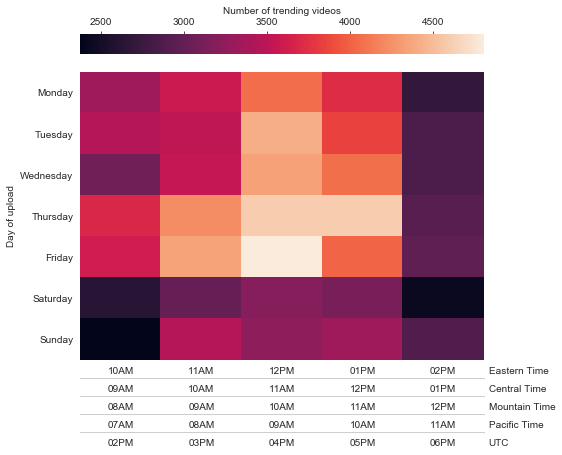

In [9]:
fig13 = plt.figure(figsize=(7, 10))
axes_dict = {}
time_labels = {
    'a': ['10AM', '11AM', '12PM', '01PM', '02PM'],
    'b': ['09AM', '10AM', '11AM', '12PM', '01PM'],
    'c': ['08AM', '09AM', '10AM', '11AM', '12PM'],
    'd': ['07AM', '08AM', '09AM', '10AM', '11AM'],
    'e': ['02PM', '03PM', '04PM', '05PM', '06PM'],
}
for sub_axe, timezone in [('a', 'Eastern Time'), ('b', 'Central Time'), ('c', 'Mountain Time'), ('d', 'Pacific Time'), ('e', 'UTC')]:
    current_ax = '13' + sub_axe
    if sub_axe == 'a':
        start_values = (0.1, 0.4, 0.8, 0.5)
        axes_dict[current_ax] = fig13.add_axes(start_values)
        day_hour_group_zoom = all_data.loc[all_data['publish_hour'].isin(['02PM','03PM','04PM','05PM','06PM']), ['publish_hour', 'publish_day', 'video_id']]
        day_hour_group_zoom = day_hour_group_zoom.pivot_table(index='publish_day', columns='publish_hour',
                                                              values='video_id', aggfunc='count')
        day_hour_group_zoom = day_hour_group_zoom.reindex(day_order, axis='index')
        day_hour_group_zoom = day_hour_group_zoom.reindex(['02PM', '03PM', '04PM', '05PM', '06PM'], axis='columns')
        sns.heatmap(day_hour_group_zoom, ax=axes_dict[current_ax], #cmap='YlGnBu',
                    cbar_kws={'label': 'Number of trending videos',
                              'use_gridspec': False,
                              'location': 'top'
                              },
                    square=False)
        axes_dict[current_ax].set(xticklabels=time_labels[sub_axe], xlabel="", ylabel="Day of upload")
        axes_dict[current_ax].annotate(timezone, xy=(1,0), xytext=(5, -6.8), ha='left', va='top',
                                        xycoords='axes fraction', textcoords='offset points')
        tick_locations = axes_dict[current_ax].get_xticks()
    else:
        x0, y0, width, height = start_values
        y0 -= 0.025
        height = 0
        start_values = x0, y0, width, height
        axes_dict[current_ax] = fig13.add_axes(start_values)
        axes_dict[current_ax].yaxis.set_visible(False)
        axes_dict[current_ax].set(xticklabels=time_labels[sub_axe], xticks=[0.1, 0.3, 0.5, 0.7, 0.9], xlabel="", ylabel="Day of upload")
        axes_dict[current_ax].annotate(timezone, xy=(1,0), xytext=(5, -6.25), ha='left', va='top',
                                        xycoords='axes fraction', textcoords='offset points')
        
figure_list.append((fig13, 'US_timezones_publish_day_hour_heatmap'))

In [15]:
graphs_path = os.path.join(realpath, 'graphs')
if not os.path.isdir(os.path.join(realpath, 'graphs')):
    os.mkdir(graphs_path)
for figure, figure_name in figure_list:
    figure.savefig(os.path.join(graphs_path, figure_name + '.png'), bbox_inches='tight')

In [ ]:
# The following are experimental plots which were ultimately scrapped

# from dateutil import tz

# def utc_to_timezone(datetime, hoursdelta):
#     return datetime + dt.timedelta(hours=hoursdelta)

# def sort_hours(time_value):
#     flat_time = int(time_value[0:2])
#     modifier = time_value[2:4]
#     if modifier == "PM":
#         flat_time += 12
#     if flat_time == 12:
#         flat_time = 0
#     if flat_time == 24:
#         flat_time = 12
#     return flat_time

# us_times = {}
# us_hours = {}
# zones_ratio = {
#     # Pacific, Mountain, Central and Eastern population proportions
#     'MO': 0.067,
#     'PA': 0.166,
#     'CE': 0.291,
#     'EA': 0.476,
# }
# zones_modifier = {
#     'PA': -8,
#     'MO': -7,
#     'CE': -6,
#     'EA': -5,
# }


# us_datetimes = all_data.loc[all_data['country'] == "US"]['publish_datetime']
# for zone, utc_difference in zones_modifier.items():
#     us_times[zone] = us_datetimes.apply(utc_to_timezone, args=(utc_difference,))
#     us_hours[zone] = us_times[zone].apply(format_time, args=('hour',))
#     #print(us_hours[zone].head(5))
#     us_hours[zone] = us_hours[zone].value_counts()
#     us_hours[zone].sort_index(inplace=True)
#     us_hours[zone] = us_hours[zone] * zones_ratio[zone]
#     print(us_hours[zone].head(5))
#     #zones_ratio[zone] # Need to split this to add a line that adds in missing hours

# test = us_hours['MO'].head(5)
# print(test)
# test.sort_index(inplace=True)
# print(test)
    

        

# #print(us_hours['MO'].head(5))
# us_hours['MO'] = us_hours['MO'] + us_hours['PA'] + us_hours['CE'] + us_hours['EA']
# #print(us_hours['MO'].value_counts())
# us_hours['PA'] = us_hours['PA'] + us_hours['CE'] + us_hours['EA']
# us_hours['CE'] = us_hours['CE'] + us_hours['EA']

# fig4, ax4 = plt.subplots(figsize=(24, 10))
# hour_order = sorted(us_hours['MO'].index.unique().tolist(), key=sort_hours)
# bar_list = []
# for zone_colour, zone in [('green', 'MO'), ('blue', 'PA'), ('purple', 'CE'), ('red', 'EA')]:
#     sns.barplot(x=us_hours[zone].index, y=us_hours[zone].values, ax=ax4, color=zone_colour, order=hour_order)
#     bar_list.append(plt.Rectangle((0, 0), 1, 1, fc=zone_colour, edgecolor = 'none'))

# legend = plt.legend(bar_list, ['Mountain', 'Pacific', 'Central', 'Eastern'], loc=1, ncol=2, prop={'size':16})
    
# sns.despine(left=True)

In [ ]:
# country_counts = all_data.groupby('country')['category'].value_counts()
# fig3, ax3 = plt.subplots(figsize=(12, 8))
# categories = country_counts.index.get_level_values('category')
# countries = country_counts.index.get_level_values('country')

# sns.barplot(country_counts.values, y=countries, hue=categories, ax=ax3)

In [ ]:
# def delta_to_hours(timedelta):
#     return(round(timedelta.seconds / 3600))
# all_data['publish_to_trend_hours'] = all_data['publish_to_trend_time'].apply(delta_to_hours)
# hour_plot = all_data['publish_to_trend_hours'].value_counts()
# ax = sns.barplot(x=hour_plot.index, y=hour_plot.values, palette='plasma')
# ax.set(xlabel="Hours from upload to trending", ylabel="Number of trending videos")